<a href="https://colab.research.google.com/github/viktoruebelhart/analyzing-financial-fraud/blob/main/analyzing_financial_fraud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This project is dedicated to building a robust solution for detecting fraudulent activities. By developing and implementing advanced analytical techniques, the project aims to identify suspicious patterns and irregularities that may indicate fraudulent behavior. The ultimate goal is to create a reliable system that can flag potentially fraudulent transactions or activities, enhancing security and supporting proactive measures against fraud.

Key stages of the process include:

*  Conducting exploratory data analysis
*  Analyzing correlations
*  Engineering features
*  Building and training models
*  Assessing model performance

dataset:
https://drive.google.com/file/d/1zjK8zQK5zvhR_r2chWI5dCjeOwASlPfb/view?usp=sharing

# Importing the dataset

In [3]:
# importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import asarray

from datetime import datetime as dt
from datetime import timedelta as td

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split

# Feature importance
from sklearn.inspection import permutation_importance

import warnings
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Alura/fraud_detection_dataset.csv')

In [5]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


- step - indicates the total time passed in hours from the start of the simulation, ranging between 1 and 744 (representing a 30-day period).

- type - specifies the type of transaction, such as deposit, withdrawal, debit, payment, or transfer.

- amount - reflects the total value involved in the transaction.

- nameOrig - identifies the customer who initiated the transaction.

- oldbalanceOrg - shows the account balance of the initiating party before the transaction occurred.

- newbalanceOrig - shows the updated balance of the origin account after the transaction.

- nameDest - refers to the intended recipient or target of the transaction.

- oldbalanceDest - captures the balance of the recipient's account prior to the transaction.

- newbalanceDest - displays the balance of the destination account after the transaction.

- isFraud - indicates if the transaction is classified as fraudulent. In this scenario, fraud is assumed to occur when a user’s account is accessed and drained through transfers, followed by a withdrawal from the destination account.

- isFlaggedFraud - marked by the bank as potential fraud if the transaction attempts to transfer an amount exceeding 200,000.

##Exploratory Data Analysis (EDA)


##check the information in our dataset and analyze classification and fulfillment

In [6]:
df.shape

(6362620, 11)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [8]:
df.isna().sum()

,0
step,0
type,0
amount,0
nameOrig,0
oldbalanceOrg,0
newbalanceOrig,0
nameDest,0
oldbalanceDest,0
newbalanceDest,0
isFraud,0


There isn't any null value in the dataset

In [9]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [17]:
df['isFraud'].value_counts()

,count
isFraud,
0,6354407
1,8213


In [18]:
percentage_frau = df['isFraud'].value_counts(normalize=True) * 100
percentage_frau

,proportion
isFraud,
0,99.870918
1,0.129082


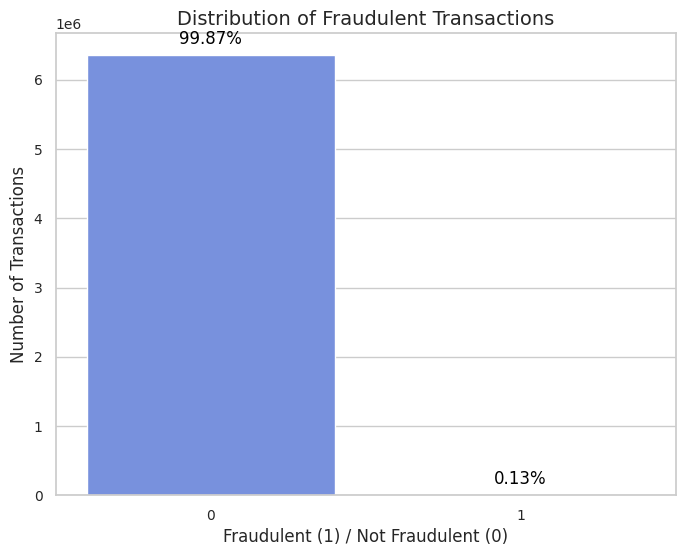

In [16]:
# Calculate the percentage of fraudulent transactions
fraud_percentage = df['isFraud'].value_counts(normalize=True) * 100

# Create the plot
plt.figure(figsize=(8, 6))
sns.set_palette("coolwarm")
ax = sns.countplot(x='isFraud', data=df)

# Customize title and axis labels
plt.title('Distribution of Fraudulent Transactions')
plt.xlabel('Fraudulent (1) / Not Fraudulent (0)')
plt.ylabel('Number of Transactions')

# Add percentage labels to the bars
for p, percentage in zip(ax.patches, fraud_percentage):
    ax.annotate(f'{percentage:.2f}%',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center',
                va='bottom',
                xytext=(0, 5),
                textcoords='offset points',
                fontsize=12,
                color='black')

plt.show()

Based on the analysis, the percentage of fraudulent transactions (isFraud) is very low, with only 0.13% of transactions marked as fraud, while 99.87% are non-fraudulent. This highly imbalanced distribution suggests a significant class imbalance, which can impact the performance of any predictive models trained on this data.

Let's begin by evaluating the effectiveness of the bank's fraud detection engine.
We started by examining the total fraud referrals that were conducted.

In [20]:
# Analyze the effectiveness of the bank's fraud detection system.
# Calculate how many fraudulent transactions were correctly identified by the bank.

true_positives = len(df[(df['isFraud'] == 1) & (df['isFlaggedFraud'] == 1)])
false_negatives = len(df[(df['isFraud'] == 1) & (df['isFlaggedFraud'] == 0)])
total_fraudulent = len(df[df['isFraud'] == 1])

bank_accuracy = (true_positives / total_fraudulent) * 100

print(f"Number of True Positives: {true_positives}")
print(f"Number of False Negatives: {false_negatives}")
print(f"Total Fraudulent Transactions: {total_fraudulent}")
print(f"Bank Accuracy in identifying fraud: {bank_accuracy:.2f}%")

Number of True Positives: 16
Number of False Negatives: 8197
Total Fraudulent Transactions: 8213
Bank Accuracy in identifying fraud: 0.19%


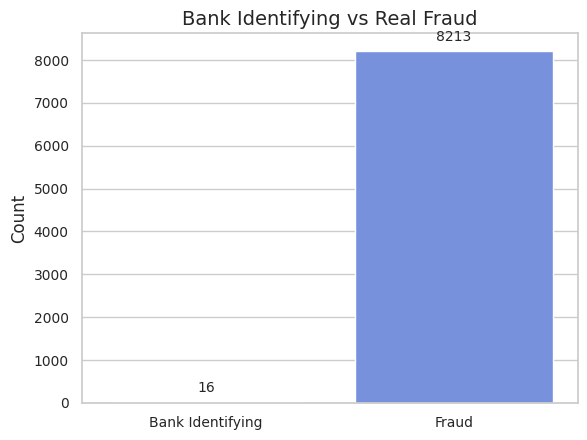

In [33]:
ax = sns.barplot(x=['Bank Identifying', 'Fraud'],
                 y=[df.isFlaggedFraud.sum(), df.isFraud.sum()])
plt.title('Bank Identifying vs Real Fraud')
plt.ylabel('Count')

# Add count labels on each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center',
                va='bottom',
                xytext=(0, 5),
                textcoords='offset points',
                fontsize=10)

plt.show()